Spustenie IPD evolučného algoritmu.
Počet protihráčov: 4
Veľkosť populácie: 150
Maximálny počet generácií: 150
gen	nevals	avg    	min   	max   
0  	150   	218.917	173.25	266.75
1  	98    	232.498	196.75	269.75
2  	87    	243.987	184.5 	276.5 
3  	82    	253.575	184.75	279.25
4  	79    	261.37 	202.5 	284.75
5  	85    	266.213	218.25	284.75
6  	93    	267.622	207   	285.5 
7  	92    	268.745	182.25	285.5 
8  	93    	269.502	189   	286   
9  	93    	272.427	187.5 	285.5 
10 	86    	272.812	226.25	288.5 
11 	92    	274.362	226.25	288.5 
12 	100   	274.232	215.75	288.5 
13 	103   	272.852	213   	287.5 
14 	99    	275.062	215.25	292.25
15 	90    	274.895	182.25	292.25
16 	98    	274.68 	227   	292.25
17 	94    	276.628	187.5 	293.25
18 	98    	278.147	226   	293.25
19 	100   	275.895	187.5 	293.25
20 	95    	278.163	236.5 	293.25
21 	87    	277.407	183.75	293.25
22 	95    	278.747	212.75	293.25
23 	91    	275.835	207.25	293.25
24 	74    	280.625	235   	293.25
25 	103   	278.175	235.5 	293.2

<Figure size 1200x800 with 0 Axes>

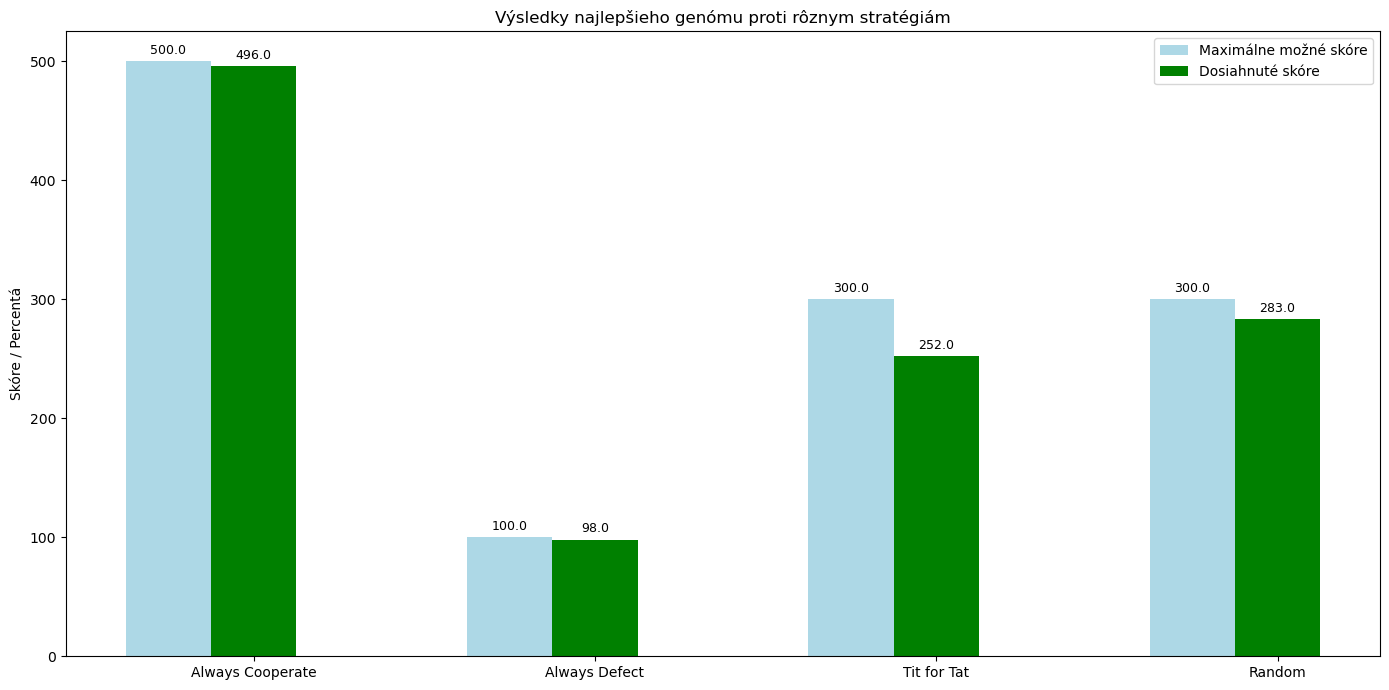


Test funkcie zrada():
-------------------------------------------------------
0 = spolupráca, 1 = zrada
Test s prázdnou históriou:
História agenta: [], História oponenta: [] -> ďalší krok: 0

Test s malou históriou:
História agenta: [0, 1], História oponenta: [0, 0] -> ďalší krok: 1

Test s tit-for-tat históriou:
História agenta: [0, 0, 1, 0, 1, 0], História oponenta: [0, 0, 0, 1, 0, 1] -> ďalší krok: 1

Test s random históriou:
História agenta: [0, 0, 1, 0, 1, 0], História oponenta: [0, 1, 1, 0, 0, 0] -> ďalší krok: 1

Test s always cooperate históriou:
História agenta: [0, 1, 1, 1, 1, 1], História oponenta: [0, 0, 0, 0, 0, 0] -> ďalší krok: 1

Test s always defect históriou:
História agenta: [0, 1, 1, 1, 1, 1], História oponenta: [0, 1, 1, 1, 1, 1] -> ďalší krok: 1


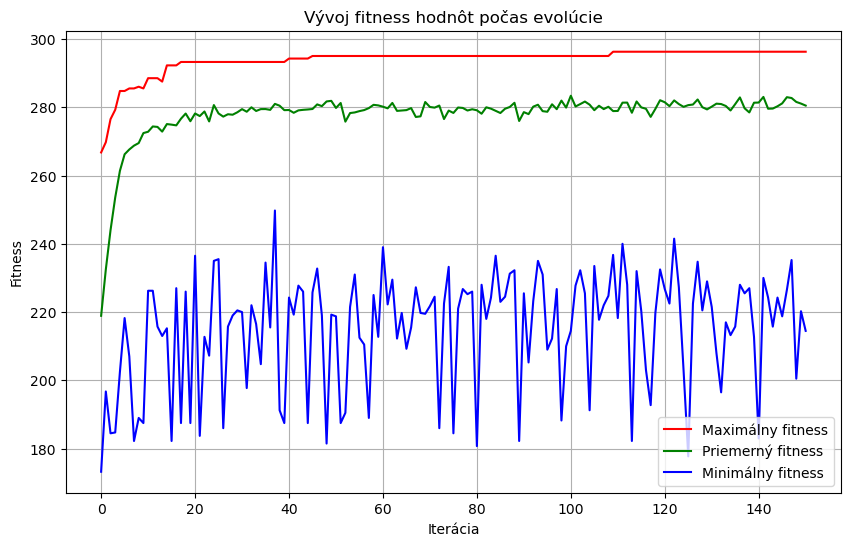

In [24]:
#!pip install deap matplotlib

import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# ======================================================================================
# konfiguracia hry
# ======================================================================================
HISTORY_LENGTH = 2           # pocet predoslych tahov ktore brat na ohlad
GENOME_LENGTH = 2**(2*HISTORY_LENGTH) # pre spravne vyuzitie genomu v tabulke
NUM_ROUNDS = 100             # pocet kol na jednu hru

# ======================================================================================
# parametre genetickeho algoritmu
# ======================================================================================
POPULATION_SIZE = 150        # pocet individualov v populacii
MUTATION_RATE = 0.2          # sanca mutacie
CROSSOVER_RATE = 0.5         # sanca krizenia
TOURNAMENT_SIZE = 4          # pocet jedincov v turnaji
ELITISM_SIZE = 10             # pocet elitnych jedincov
MAX_GENERATIONS = 150        # pocet generacii

# hodnoty pre geny (0 = spolupraca, 1 = zrada)
MIN_STRATEGY_VALUE = 0
MAX_STRATEGY_VALUE = 1

# ======================================================================================
# protihraci (False ak nechceme)
# ======================================================================================
ALWAYSCOOPERATE = True
ALWAYSDEFECT = True
TITFORTAT = True
RANDOM = True

# ======================================================================================
# tabulka iterovaneho vaznovho dilema
# ======================================================================================
IPDTABLE = {
    (0, 0): (3, 3),  # obaja spolupracuju
    (0, 1): (0, 5),  # agent spolupracuje, oponent zradi
    (1, 0): (5, 0),  # agent zradi, oponent spolupracuje
    (1, 1): (1, 1)   # obaja zradia
}

# ======================================================================================
# strategie superov
# ======================================================================================

def always_cooperate(history=None):
    # vzdy spolupracovat
    return 0

def always_defect(history=None):
    # vzdy zradit
    return 1

def tit_for_tat(opp_hist):
    # spolupracovat na zaciatku potom kopirovat
    return opp_hist[-1] if opp_hist else 0

def random_strategy(history=None):
    # nahoda
    return random.randint(0, 1)

# ======================================================================================
# inicializacia zoznamu oponentov podla vybranych strategii
# ======================================================================================
OPPONENTS = []

if ALWAYSCOOPERATE:
    OPPONENTS.append(("Always Cooperate", always_cooperate))
if ALWAYSDEFECT:
    OPPONENTS.append(("Always Defect", always_defect))
if TITFORTAT:
    OPPONENTS.append(("Tit for Tat", tit_for_tat))
if RANDOM:
    OPPONENTS.append(("Random", random_strategy))

# ======================================================================================
# funkcie pre geneticky algoritmus
# ======================================================================================

def decode_strategy(genome, agent_history, opponent_history):
    # vrati rozhodnutie na zaklade genomu a historie tahov
    if len(agent_history) < HISTORY_LENGTH or len(opponent_history) < HISTORY_LENGTH:
        return 0  # ak nie je dostatok historie, spolupracujeme
    
    # ziskanie poslednych tahov z historie
    recent_agent_moves = agent_history[-HISTORY_LENGTH:]
    #print(f"recent moves: {recent_agent_moves}")
    recent_opponent_moves = opponent_history[-HISTORY_LENGTH:]
    
    # vytvorenie indexu do genomu na zaklade historie
    genome_index = 0
    
    # postupne vytvarame index z historie oboch hracov napr:
    # pre HISTORY_LENGTH=2 vytvorime index v rozpati 0-15
    # reprezentujuci vsetky mozne kombinacie 4 bitov historie
    # napr. [agent=0,oponent=1,agent=1,oponent=0] = index 6
    # v skutku na toto by som sam asi nikdy nedosiel ale cital som https://www.jessiefin.com/assets/pdf/tog-coop-ipd.pdf
    for i in range(HISTORY_LENGTH):
        # posun dolava pre miesto na dalsi bit
        genome_index = genome_index << 1
        # pridanie tahu agenta ako dalsi bit
        genome_index = genome_index | recent_agent_moves[i]
        
        # dalsi posun dolava
        genome_index = genome_index << 1
        # pridanie tahu oponenta ako dalsi bit
        genome_index = genome_index | recent_opponent_moves[i]
    
    # vrat zakodovane rozhodnutie z genomu
    # genom obsahuje 0 alebo 1 pre kazdu moznu kombinaciu historie
    # tieto hodnoty sa evolvuju genetickym algoritmom
    return genome[genome_index]

def play_game(genome, opponent_strategy, num_rounds=NUM_ROUNDS):
    # spusti hru a vrati skore agenta
    agent_hist = []
    opp_hist = []
    agent_score = 0
    
    for _ in range(num_rounds):
        # agent cini podla genomu a historie 
        agent_move = decode_strategy(genome, agent_hist, opp_hist)
        
        # ocakava to tit-for-tat podla toho co robil predtym agent
        opp_move = opponent_strategy(agent_hist)
        
        agent_hist.append(agent_move)
        opp_hist.append(opp_move)
        
        # vyhodnotenie kola
        agent_reward, _ = IPDTABLE[(agent_move, opp_move)]
        agent_score += agent_reward
    
    return agent_score

def evaluate_fitness(genome):
    # vyhodnoti fitness genomu
    total_score = 0
    
    # docasne nastavit globalnu premennu
    global BEST_GENOME
    original_genome = BEST_GENOME
    BEST_GENOME = genome
    
    # prechadzame vsetky strategie a superov a vyhodnocujeme ich
    # tym ze spustame hru s genomom
    for _, opponent_strategy in OPPONENTS:
        game_score = play_game(genome, opponent_strategy)
        if game_score > 0:
            total_score += game_score

    # vratit spiatocne globalnu premennu
    BEST_GENOME = original_genome
    
    # vystup je priemerne skore
    average_score = total_score / len(OPPONENTS)
    return (average_score,)

# ======================================================================================
# vymaz existujuce triedy deap aby neboli chyby
# ======================================================================================
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# ======================================================================================
# inicializacia deap toolboxu
# ======================================================================================

# vytvorenie classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()

# registracia funkcii do toolboxu
toolbox.register("gene_maker", random.randint, MIN_STRATEGY_VALUE, MAX_STRATEGY_VALUE)
toolbox.register("individual_creator", tools.initRepeat, creator.Individual, 
                 toolbox.gene_maker, n=GENOME_LENGTH)
toolbox.register("population_creator", tools.initRepeat, list, toolbox.individual_creator)

# operatory gen. algoritmu
toolbox.register("evaluate", evaluate_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=MIN_STRATEGY_VALUE, up=MAX_STRATEGY_VALUE, 
                 indpb=MUTATION_RATE)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

# statistiky
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # avg fitness
stats.register("min", np.min)   # min fitness
stats.register("max", np.max)   # max fitness

# ======================================================================================
# implementacia funkcie zrada na zaklade vyevolvovaneho genomu
# ======================================================================================

# globalna premenna pre ulozenie najlepsieho genomu
BEST_GENOME = None

def zrada(moja_historia, protihracova_historia):
    # vracia nasledujuci tah (0 = spolupraca, 1 = zrada) 
    # na zaklade historie vlastnych tahov a tahov protihraca

    global BEST_GENOME
    
    # ak nemame najlepsi genom, vratime defaultne 0 (spolupraca)
    if BEST_GENOME is None:
        return 0
    
    #print(f"Najlepsi genom nacitany v zrade: {BEST_GENOME}")
    
    # dependentna na decode_strategy
    return decode_strategy(BEST_GENOME, moja_historia, protihracova_historia)

# ======================================================================================
# hlavny program
# ======================================================================================

def interpret_strategy(best_genome):
  
    # Interpretácia najlepšej stratégie agenta na základe histórie.

    print("\nInterpretácia najlepšej stratégie:")
    print("-" * 55)
    print(f"{'História agenta':<20} {'História oponenta':<20} {'Ďalší krok agenta':<15}")
    print("-" * 55)

    for i, decision in enumerate(best_genome):
        # Prevedieme index na binárnu reprezentáciu histórie
        binary = format(i, f'0{2 * HISTORY_LENGTH}b')
        agent_hist = binary[::2]  # História agenta (každý druhý bit)
        opp_hist = binary[1::2]   # História oponenta (každý druhý bit)

        # Preložíme históriu do čitateľnej podoby
        agent_hist_str = ''.join(['Spol. ' if bit == '0' else 'Zrada ' for bit in agent_hist])
        opp_hist_str = ''.join(['Spol. ' if bit == '0' else 'Zrada ' for bit in opp_hist])

        # Rozhodnutie agenta
        action = "Spolupráca" if decision == 0 else "Zrada"

        # Výpis interpretácie v tabuľkovom formáte
        print(f"{agent_hist_str:<20} {opp_hist_str:<20} {action:<15}")

def evaluate_best_genome_against_opponents(best_genome):
    """
    Vyhodnotí úspešnosť najlepšieho genómu proti každému oponentovi samostatne
    a zobrazí detailné výsledky vrátane maximálneho dosiahnuteľného skóre.
    """
    print("\n=== Vyhodnotenie najlepšieho genómu proti jednotlivým oponentom ===")
    print("-" * 90)
    print(f"{'Stratégia oponenta':<20} {'Max skóre':<15} {'Skóre agenta':<15}")
    print("-" * 90)
    
    total_score = 0
    total_max_score = 0
    results = []
    
    # Hranie proti každému oponentovi
    for opponent_name, opponent_strategy in OPPONENTS:
        # Vypočítame maximálne možné skóre pre daného protihráča
        if opponent_name == "Always Cooperate":
            # Proti Always Cooperate je maximum 5 bodov za kolo (zrada proti spolupráci)
            max_possible_score = 5 * NUM_ROUNDS
        elif opponent_name == "Always Defect":
            # Proti Always Defect je maximum 1 bod za kolo (oba zradia)
            max_possible_score = 1 * NUM_ROUNDS
        else:
            # Pre ostatných súperov predpokladáme ideálny scenár 3 body za kolo (oba spolupracujú)
            # alebo lepšie 5 bodov ak sa podarí zradiť spolupracujúceho súpera
            max_possible_score = 3 * NUM_ROUNDS  # Konzervatívny odhad, v skutočnosti môže byť vyšší
            
        # Hranie aktuálnej hry
        game_score = play_game(best_genome, opponent_strategy)
        avg_score_per_round = game_score / NUM_ROUNDS
        
        
        results.append((opponent_name, max_possible_score, game_score))
        total_score += game_score
        total_max_score += max_possible_score
        
        print(f"{opponent_name:<20} {max_possible_score:<15} {game_score:<15.2f}")
    
    # Celkové výsledky
    print("-" * 90)
    total_percentage = (total_score / total_max_score) * 100 if total_max_score > 0 else 0
    avg_total = total_score / len(OPPONENTS)
    print(f"{'CELKOVO':<20} {total_max_score:<15} {total_score:<15.2f}")
    
    # Vizualizácia výsledkov
    plt.figure(figsize=(12, 8))
    
    # Pripravíme údaje pre graf
    opponent_names = [r[0] for r in results]
    max_scores = [r[1] for r in results]
    actual_scores = [r[2] for r in results]
    
    # Vytvoríme stĺpcový graf
    x = np.arange(len(opponent_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(14, 7))
    bars1 = ax.bar(x - width, max_scores, width, label='Maximálne možné skóre', color='lightblue')
    bars2 = ax.bar(x, actual_scores, width, label='Dosiahnuté skóre', color='green')
    
    # Upravíme graf
    ax.set_ylabel('Skóre / Percentá')
    ax.set_title('Výsledky najlepšieho genómu proti rôznym stratégiám')
    ax.set_xticks(x)
    ax.set_xticklabels(opponent_names)
    ax.legend()
    
    # Pridáme hodnoty nad stĺpce
    def autolabel(bars, format_str='{:.1f}'):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(format_str.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 bodov vertikálne posunutie
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
    
    autolabel(bars1)
    autolabel(bars2)
    
    plt.tight_layout()
    plt.show()
    
    return results

def plot_evolution(logs):
    # vykreslenie grafu vyvoja fitness hodnot
    gen = logs.select("gen")
    fit_avg = logs.select("avg")
    fit_min = logs.select("min")
    fit_max = logs.select("max")
    
    plt.figure(figsize=(10, 6))
    plt.plot(gen, fit_max, "r-", label="Maximálny fitness")
    plt.plot(gen, fit_avg, "g-", label="Priemerný fitness")
    plt.plot(gen, fit_min, "b-", label="Minimálny fitness")
    plt.title("Vývoj fitness hodnôt počas evolúcie")
    plt.xlabel("Iterácia")
    plt.ylabel("Fitness")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

def print_v_zrade(moja_h, protihrac_h, result):
     print(f"História agenta: {moja_h}, História oponenta: {protihrac_h} -> ďalší krok: {result}")

def test_funkcie_zrada():
    # testovanie implementacie funkcie zrada
    print("\nTest funkcie zrada():")
    print("-" * 55)
    print("0 = spolupráca, 1 = zrada")

    # ====================================
    # test s prazdnou historiou
    # ====================================
    print("Test s prázdnou históriou:")
    moja_hist = []
    protihrac_hist = []
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)

    # ====================================
    # test s malou historiou
    # ====================================
    print("\nTest s malou históriou:")
    moja_hist = [0, 1]  # spolupraca, zrada
    protihrac_hist = [0, 0]  # spolupraca, spolupraca
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)
    
    # ====================================
    # test s titfortat historiou 
    # ====================================
    print("\nTest s tit-for-tat históriou:")
    moja_hist =      [0, 0, 1, 0, 1, 0]
    protihrac_hist = [0, 0, 0, 1, 0, 1]
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)

    # ====================================
    # test s random historiou 
    # ====================================
    print("\nTest s random históriou:")
    moja_hist =      [0, 0, 1, 0, 1, 0]
    protihrac_hist = [random.choice([0, 1]) for _ in moja_hist]
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)

    # ====================================
    # test s always cooperate historiou 
    # ====================================
    print("\nTest s always cooperate históriou:")
    moja_hist =      [0, 1, 1, 1, 1, 1]
    protihrac_hist = [0, 0, 0, 0, 0, 0]
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)

    # ====================================
    # test s always defect historiou 
    # ====================================
    print("\nTest s always defect históriou:")
    moja_hist =      [0, 1, 1, 1, 1, 1]
    protihrac_hist = [0, 1, 1, 1, 1, 1]
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)



if __name__ == "__main__":
    print("Spustenie IPD evolučného algoritmu.")
    print(f"Počet protihráčov: {len(OPPONENTS)}")
    print(f"Veľkosť populácie: {POPULATION_SIZE}")
    print(f"Maximálny počet generácií: {MAX_GENERATIONS}")
    
    # vytvorenie pociatocnej populacie
    population = toolbox.population_creator(n=POPULATION_SIZE)
    
    # inicializacia hof (hall of fame) pre sledovanie najlepsich jedincov
    hof = tools.HallOfFame(ELITISM_SIZE)
    
    # inicializacia logbook pre zaznamenavanie statistik
    logs = tools.Logbook()
    
    # spustenie genetickeho algoritmu
    population, logs = algorithms.eaSimple(
        population, 
        toolbox,
        cxpb=CROSSOVER_RATE,
        mutpb=MUTATION_RATE,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True
    )
    
    # top hof = best genome
    best_genome = hof[0]
    print("Najlepší genóm:", best_genome)
    print("Fitness hodnota:", best_genome.fitness.values[0])
     
    # ulozenie najlepsieho genomu pre funkciu zrada
    BEST_GENOME = best_genome
    
    # interpretacia 
    interpret_strategy(best_genome)

    # Vyhodnotenie najlepšieho genómu proti všetkým oponentom
    evaluate_best_genome_against_opponents(best_genome)
    
    # test funkcie zrada resp. test najlepsej strategie
    test_funkcie_zrada()

    # vykreslenie grafu
    plot_evolution(logs)